In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# Load embeddings (col 0 = length, cols 1-384 = embeddings)
data = np.load('Runs/embeddings_SFE_SE_1.npy')
lengths = data[:, 0]
embeddings = data[:, 1:]
print(f'Loaded {embeddings.shape[0]} embeddings with {embeddings.shape[1]} dimensions')
print(f'Length range: {lengths.min():.0f} - {lengths.max():.0f}')

# Pre-compute L2-normalized embeddings for cosine distance via dot product
norms = np.linalg.norm(embeddings, axis = 1, keepdims = True)
embeddings_normed = embeddings / norms
del norms

# Load embedding IDs
embedding_ids = np.loadtxt('Runs/ids_SFE_SE_1.txt', dtype = str)
print(f'Loaded {embedding_ids.shape[0]} embedding IDs')

# Load k-mer frequencies (col 0 = length, cols 1-2772 = k-mers)
kmers = np.load('Runs/kmers_SFE_SE_1.npy')
print(f'Loaded k-mer data: {kmers.shape}')

# Extract k-mer frequencies by size (new format without 7-mers)
six_mers = kmers[:, 1:2081]        # 2080 features
five_mers = kmers[:, 2081:2593]    # 512 features
four_mers = kmers[:, 2593:2729]    # 136 features
three_mers = kmers[:, 2729:2761]   # 32 features
two_mers = kmers[:, 2761:2771]     # 10 features
one_mers = kmers[:, 2771:2773]     # 2 features

print(f'6-mers: {six_mers.shape[1]} features')
print(f'5-mers: {five_mers.shape[1]} features')
print(f'4-mers: {four_mers.shape[1]} features')
print(f'3-mers: {three_mers.shape[1]} features')
print(f'2-mers: {two_mers.shape[1]} features')
print(f'1-mers: {one_mers.shape[1]} features')

Loaded 6693829 embeddings with 384 dimensions
Length range: 1000 - 10208085
Loaded 6693829 embedding IDs
Loaded k-mer data: (6693829, 2773)
6-mers: 2080 features
5-mers: 512 features
4-mers: 136 features
3-mers: 32 features
2-mers: 10 features
1-mers: 2 features



Number of pairwise distances: 49,995,000
Distance range: 2.67 - 69.98
Mean: 27.33, Std: 7.51


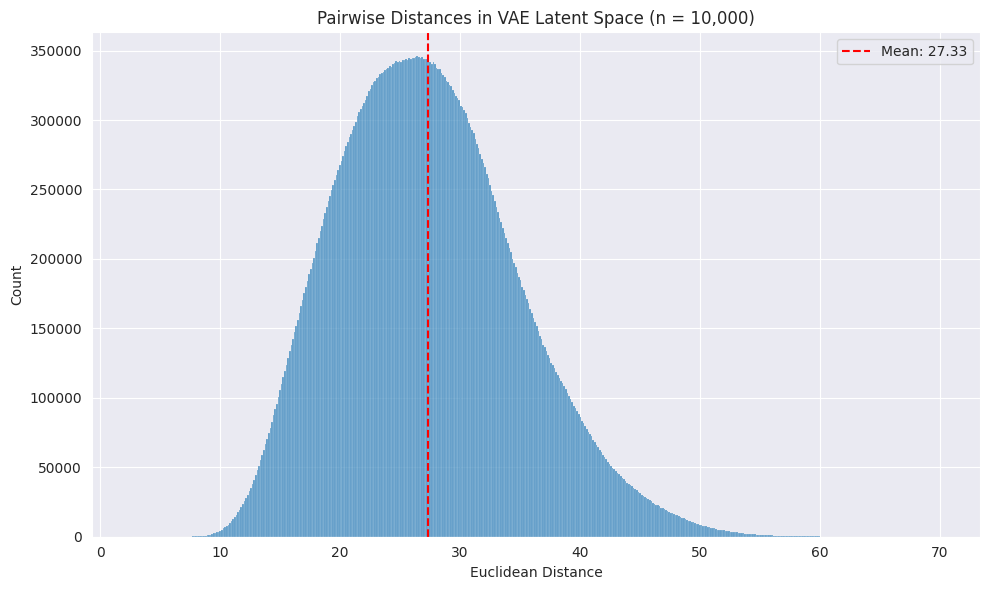

In [11]:
# Randomly sample 10,000 entries
rng = np.random.default_rng(42)
idx = rng.choice(len(embeddings), size = 10_000, replace = False)
sample = embeddings[idx]

# Calculate pairwise Euclidean distances (float32 via squared-distance decomposition)
sq_norms = np.einsum('ij,ij->i', sample, sample)
sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * (sample @ sample.T)
np.maximum(sq_dists, 0, out = sq_dists)  # Clamp numerical noise
np.fill_diagonal(sq_dists, 0)
# Extract upper triangle (same as pdist output)
distances = np.sqrt(sq_dists[np.triu_indices(len(sample), k = 1)])

print(f'\nNumber of pairwise distances: {len(distances):,}')
print(f'Distance range: {distances.min():.2f} - {distances.max():.2f}')
print(f'Mean: {distances.mean():.2f}, Std: {distances.std():.2f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(distances, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances.mean():.2f}')
ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Distances in VAE Latent Space (n = 10,000)')
ax.legend()
plt.tight_layout()
plt.show()
del sq_norms, sq_dists

Number of pairwise distances: 49,995,000
Distance range: 0.0252 - 1.3339
Mean: 0.9998, Std: 0.0607


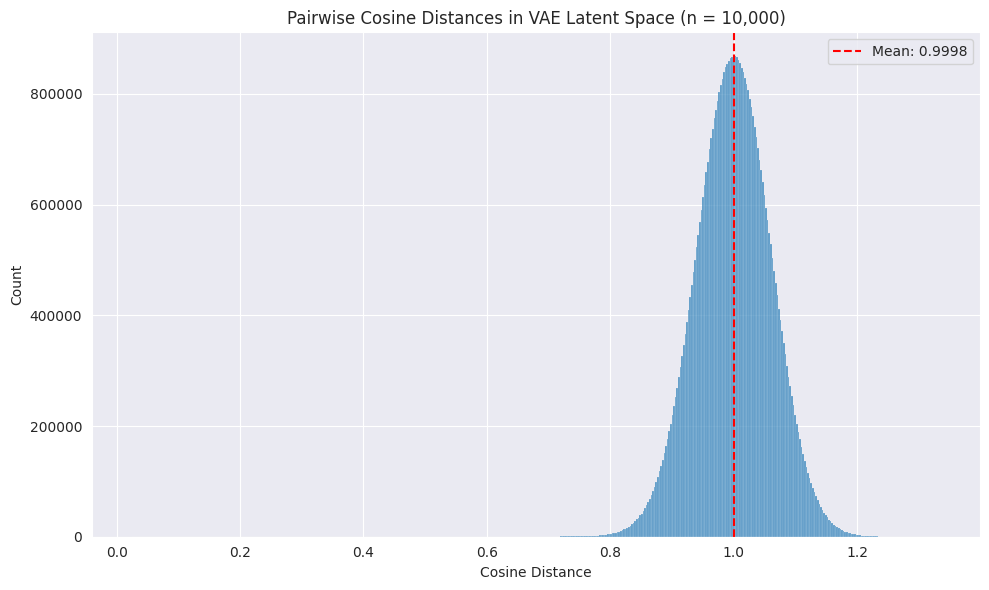

In [12]:
# Calculate pairwise cosine distances (using same sample, float32 via dot product)
sample_norms = np.linalg.norm(sample, axis = 1, keepdims = True)
sample_normed = sample / sample_norms
cos_sims = sample_normed @ sample_normed.T
np.clip(cos_sims, -1, 1, out = cos_sims)
cos_dists = 1 - cos_sims
cosine_distances = cos_dists[np.triu_indices(len(sample), k = 1)]

print(f'Number of pairwise distances: {len(cosine_distances):,}')
print(f'Distance range: {cosine_distances.min():.4f} - {cosine_distances.max():.4f}')
print(f'Mean: {cosine_distances.mean():.4f}, Std: {cosine_distances.std():.4f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(cosine_distances, bins = 500, alpha = 0.7, ax = ax)
ax.axvline(cosine_distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {cosine_distances.mean():.4f}')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Cosine Distances in VAE Latent Space (n = 10,000)')
ax.legend()
plt.tight_layout()
plt.show()
del sample_normed, cos_sims, cos_dists

In [ ]:
## Pick a random sequence
##rng = np.random.default_rng(42)
#random_idx = rng.integers(len(embeddings))
#random_id = embedding_ids[random_idx]
#print(f'Random sequence: index {random_idx}, ID {random_id}')
#
## Calculate cosine distance from random sequence to all others (float32 via dot product)
#random_normed = embeddings_normed[random_idx:random_idx + 1]
#distances_from_random = 1 - (random_normed @ embeddings_normed.T).ravel()
#distances_from_random = np.delete(distances_from_random, random_idx)
#del random_normed
#
#print(f'Distances from random sequence to {len(distances_from_random):,} others')
#print(f'Distance range: {distances_from_random.min():.4f} - {distances_from_random.max():.4f}')
#print(f'Mean: {distances_from_random.mean():.4f}, Std: {distances_from_random.std():.4f}')
#
## Plot histogram
#fig, ax = plt.subplots(figsize = (10, 6))
#sns.histplot(distances_from_random, bins = 500, alpha = 0.7, ax = ax)
#ax.axvline(distances_from_random.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances_from_random.mean():.4f}')
#ax.set_xlabel('Cosine Distance')
#ax.set_ylabel('Count')
#ax.set_title(f'Cosine Distance from Random Sequence ({random_id}) to All Others')
#ax.legend()
#plt.tight_layout()
#plt.show()

In [ ]:
## Filter to sequences within distance threshold
#distance_threshold = 0.7
#close_mask = distances_from_random < distance_threshold
#close_distances = distances_from_random[close_mask]
#print(f'Sequences within {distance_threshold} cosine distance: {len(close_distances):,}')
#
#if len(close_distances) > 0:
#    print(f'Distance range: {close_distances.min():.4f} - {close_distances.max():.4f}')
#    print(f'Mean: {close_distances.mean():.4f}, Std: {close_distances.std():.4f}')
#
#    # Plot histogram
#    fig, ax = plt.subplots(figsize = (10, 6))
#    sns.histplot(close_distances, bins = 50, alpha = 0.7, ax = ax)
#    ax.axvline(close_distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {close_distances.mean():.4f}')
#    ax.set_xlabel('Cosine Distance')
#    ax.set_ylabel('Count')
#    ax.set_title(f'Cosine Distance from Random Sequence ({random_id}) - Close Neighbors Only (< {distance_threshold})')
#    ax.legend()
#    plt.tight_layout()
#    plt.show()
#else:
#    print(f'No sequences found within {distance_threshold} cosine distance')

Total 6-mer frequency values: 13,923,164,320
Range: 0.000000 - 0.499301
Mean: 0.000481, Std: 0.000730


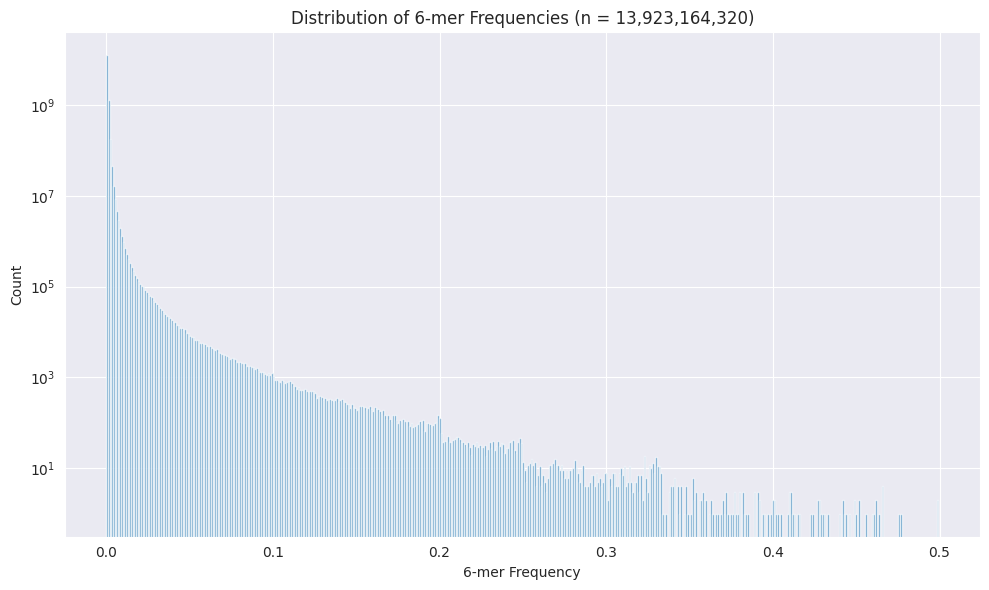

In [13]:
# Analyze 6-mer frequency distribution (using six_mers view, no flatten)
print(f'Total 6-mer frequency values: {six_mers.size:,}')
print(f'Range: {six_mers.min():.6f} - {six_mers.max():.6f}')
print(f'Mean: {six_mers.mean():.6f}, Std: {six_mers.std():.6f}')

# Compute histogram in chunks to avoid 56 GB flatten
bins = np.linspace(six_mers.min(), six_mers.max(), 501)
counts = np.zeros(len(bins) - 1, dtype = np.int64)
chunk_size = 100_000
for start in range(0, len(six_mers), chunk_size):
    chunk = six_mers[start:start + chunk_size].ravel()
    c, _ = np.histogram(chunk, bins = bins)
    counts += c

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
bin_widths = np.diff(bins)
ax.bar(bins[:-1], counts, width = bin_widths, alpha = 0.7, align = 'edge')
ax.set_yscale('log')
ax.set_xlabel('6-mer Frequency')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of 6-mer Frequencies (n = {six_mers.size:,})')
plt.tight_layout()
plt.show()

In [ ]:
## Analyze 6-mer frequency distribution
## How many 6-mers occur less than 1% of the time
#threshold = 0.01
#rare_counts = np.sum(six_mers < threshold, axis = 1)
#
#print(f'6-mer rarity analysis (threshold: {threshold * 100:.0f}%)')
#print(f'Total 6-mers per sequence: {six_mers.shape[1]}')
#print(f'Rare 6-mers per sequence (< {threshold * 100:.0f}%):')
#print(f'  Mean: {rare_counts.mean():.1f}')
#print(f'  Min: {rare_counts.min()}')
#print(f'  Max: {rare_counts.max()}')
#print(f'  Median: {np.median(rare_counts):.0f}')
#
## Plot histogram
#fig, ax = plt.subplots(figsize = (10, 6))
#sns.histplot(rare_counts, bins = 100, alpha = 0.7, ax = ax)
#ax.axvline(rare_counts.mean(), color = 'red', linestyle = '--', label = f'Mean: {rare_counts.mean():.1f}')
#ax.set_xlabel(f'Number of 6-mers with frequency < {threshold * 100:.0f}%')
#ax.set_ylabel('Count (sequences)')
#ax.set_title(f'Distribution of Rare 6-mer Counts (n = {len(rare_counts):,})')
#ax.legend()
#plt.tight_layout()
#plt.show()

Sampled 100,000 sequences
Sequences with at least one neighbor within 5.0 Euclidean distance: 920 (0.92%)
Minimum distance found: 0.0271
Mean nearest neighbor distance: 17.7208


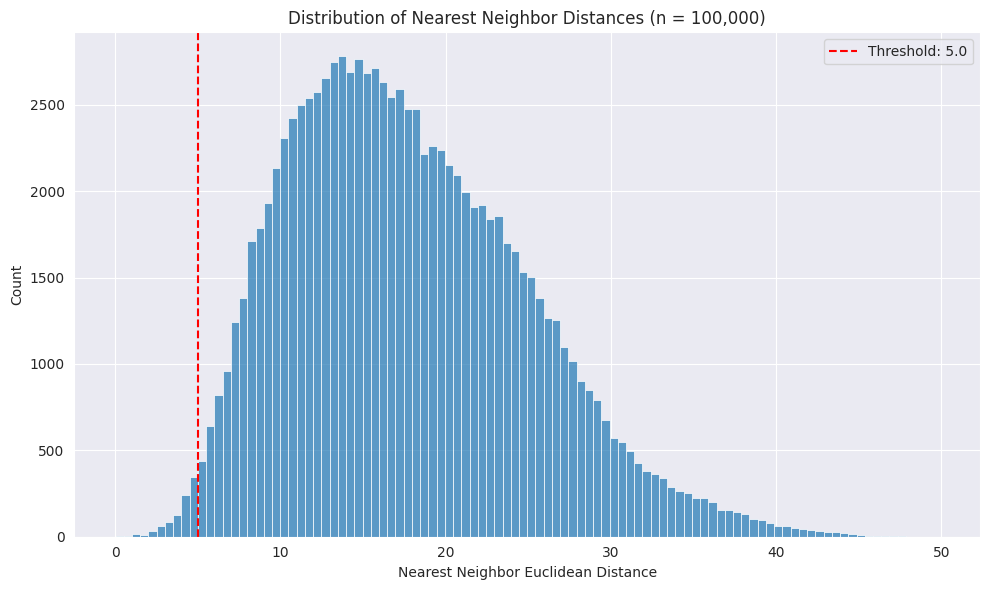

In [16]:
# Sample 100,000 sequences and check for close neighbors (float32 Euclidean)
sample_size = 100_000
neighbor_threshold = 5.0

rng_sample = np.random.default_rng(123)
sample_idx = rng_sample.choice(len(embeddings), size = sample_size, replace = False)
sample_embeddings = embeddings[sample_idx]

# Pre-compute squared norms for ||a-b||² = ||a||² + ||b||² - 2·a·b
sq_norms = np.einsum('ij,ij->i', sample_embeddings, sample_embeddings)

# Compute nearest-neighbor distances in chunks (~2 GB per chunk in float32)
min_distances = np.full(sample_size, np.inf, dtype = np.float32)
chunk_size = 5_000
for start in range(0, sample_size, chunk_size):
    end = min(start + chunk_size, sample_size)
    # Squared Euclidean distances
    sq_dists = sq_norms[start:end, None] + sq_norms[None, :] - 2 * (sample_embeddings[start:end] @ sample_embeddings.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    # Set self-distances to inf
    for i in range(end - start):
        sq_dists[i, start + i] = np.inf
    min_distances[start:end] = np.sqrt(sq_dists.min(axis = 1))
    del sq_dists

has_close_neighbor = min_distances < neighbor_threshold

print(f'Sampled {sample_size:,} sequences')
print(f'Sequences with at least one neighbor within {neighbor_threshold} Euclidean distance: {has_close_neighbor.sum():,} ({100 * has_close_neighbor.mean():.2f}%)')
print(f'Minimum distance found: {min_distances.min():.4f}')
print(f'Mean nearest neighbor distance: {min_distances.mean():.4f}')

# Plot histogram of minimum distances
fig, ax = plt.subplots(figsize = (10, 6))
sns.histplot(min_distances, bins = 100, alpha = 0.7, ax = ax)
ax.axvline(neighbor_threshold, color = 'red', linestyle = '--', label = f'Threshold: {neighbor_threshold}')
ax.set_xlabel('Nearest Neighbor Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Nearest Neighbor Distances (n = {sample_size:,})')
ax.legend()
plt.tight_layout()
plt.show()

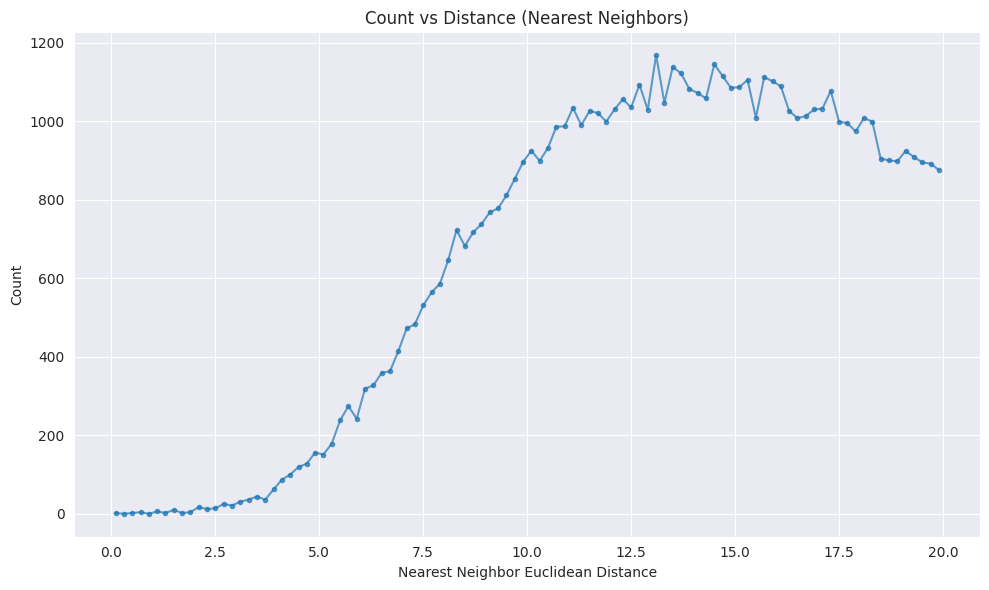

Linear fit: count = 66.3 * distance + -13.3
R² = 0.8060


In [17]:
# Plot count vs distance (binned)
max_dist = 20.0
bins = np.linspace(0, max_dist, 101)
bin_centers = (bins[:-1] + bins[1:]) / 2
counts, _ = np.histogram(min_distances[min_distances < max_dist], bins = bins)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(bin_centers, counts, 'o-', markersize = 3, alpha = 0.7)
ax.set_xlabel('Nearest Neighbor Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Count vs Distance (Nearest Neighbors)')
plt.tight_layout()
plt.show()

# Fit a linear regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(bin_centers, counts)
print(f'Linear fit: count = {slope:.1f} * distance + {intercept:.1f}')
print(f'R² = {r_value**2:.4f}')

TWO-NN intrinsic dimensionality estimate: d̂ = 7.61
Valid μ values: 100,000 / 100,000
μ range: 1.000000 - 36203352.644635, mean: 725.108952


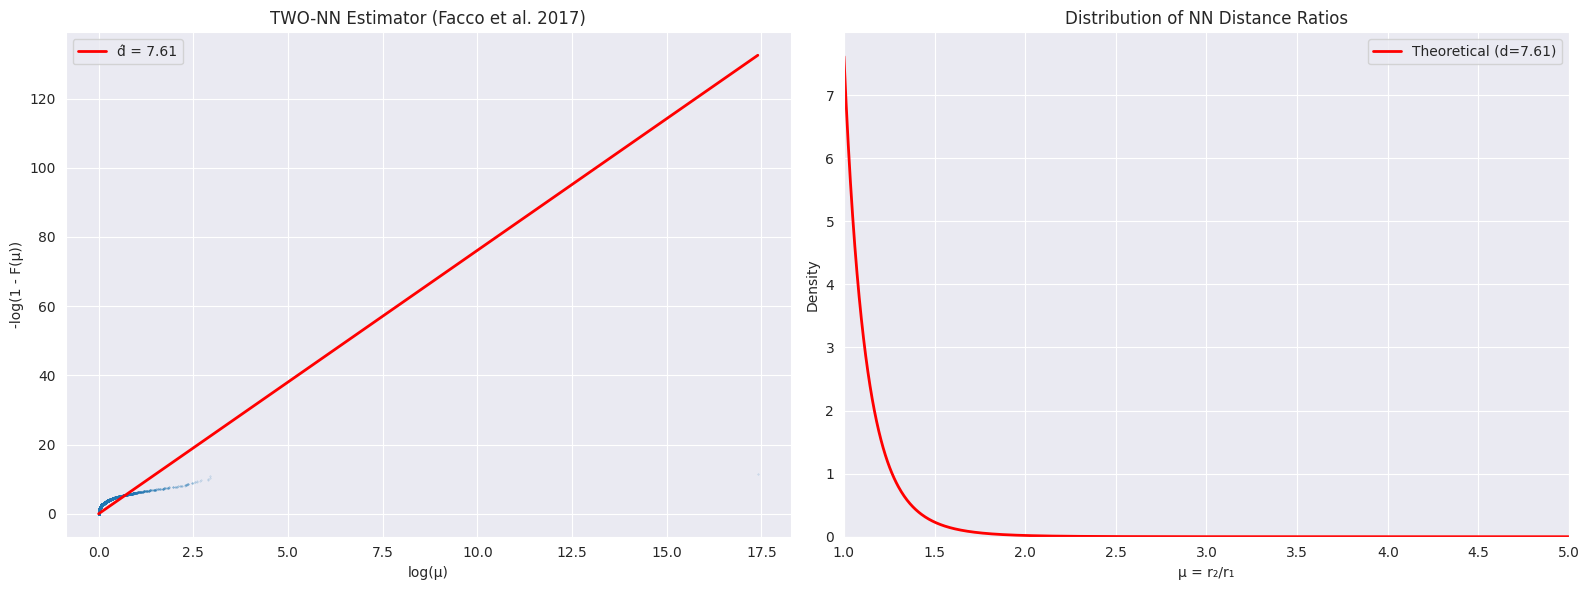

In [20]:
# TWO-NN intrinsic dimensionality estimator (Facco et al. 2017)
# Uses sample_embeddings from cell 8

# Cast to float64 for distance precision (100K × 384 = ~300 MB)
sample_f64 = sample_embeddings.astype(np.float64)
sq_norms_f64 = np.einsum('ij,ij->i', sample_f64, sample_f64)

# Find two nearest neighbors per point in chunks (~4 GB per chunk in float64)
n_sample = len(sample_f64)
nn1 = np.full(n_sample, np.inf)
nn2 = np.full(n_sample, np.inf)
chunk_size = 5_000
for start in range(0, n_sample, chunk_size):
    end = min(start + chunk_size, n_sample)
    sq_dists = sq_norms_f64[start:end, None] + sq_norms_f64[None, :] - 2 * (sample_f64[start:end] @ sample_f64.T)
    np.maximum(sq_dists, 0, out = sq_dists)
    # Set self-distances to inf
    for i in range(end - start):
        sq_dists[i, start + i] = np.inf
    # Two smallest squared distances per row
    top2_sq = np.partition(sq_dists, 1, axis = 1)[:, :2]
    top2_sq.sort(axis = 1)
    nn1[start:end] = np.sqrt(top2_sq[:, 0])
    nn2[start:end] = np.sqrt(top2_sq[:, 1])
    del sq_dists, top2_sq

del sample_f64, sq_norms_f64

# Compute μ = r₂/r₁
mu = nn2 / nn1
valid = np.isfinite(mu) & (mu > 1)
mu = np.sort(mu[valid])

# Empirical CDF
n = len(mu)
F_emp = np.arange(1, n + 1) / n

# Fit: from F(μ) = 1 - μ^(-d), we get -log(1 - F) = d * log(μ)
# Slope through origin = d̂
x = np.log(mu[:-1])  # exclude last point where F_emp = 1
y = -np.log(1 - F_emp[:-1])
d_hat = np.sum(x * y) / np.sum(x * x)

print(f'TWO-NN intrinsic dimensionality estimate: d̂ = {d_hat:.2f}')
print(f'Valid μ values: {n:,} / {n_sample:,}')
print(f'μ range: {mu.min():.6f} - {mu.max():.6f}, mean: {mu.mean():.6f}')

# Plot
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

# Left: log(μ) vs -log(1-F) with fitted line
axes[0].scatter(x, y, s = 0.1, alpha = 0.3)
x_fit = np.linspace(0, x.max(), 100)
axes[0].plot(x_fit, d_hat * x_fit, 'r-', linewidth = 2, label = f'd̂ = {d_hat:.2f}')
axes[0].set_xlabel('log(μ)')
axes[0].set_ylabel('-log(1 - F(μ))')
axes[0].set_title('TWO-NN Estimator (Facco et al. 2017)')
axes[0].legend()

# Right: histogram of μ with theoretical PDF f(μ) = d * μ^(-(d+1))
axes[1].hist(mu, bins = 100, alpha = 0.7, density = True)
mu_theory = np.linspace(1, min(5, mu.max()), 1000)
pdf_theory = d_hat * mu_theory ** (-(d_hat + 1))
axes[1].plot(mu_theory, pdf_theory, 'r-', linewidth = 2, label = f'Theoretical (d={d_hat:.2f})')
axes[1].set_xlabel('μ = r₂/r₁')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of NN Distance Ratios')
axes[1].legend()
axes[1].set_xlim(1, min(5, mu.max()))

plt.tight_layout()
plt.show()

In [21]:
# Compare multiple intrinsic dimension estimators (scikit-dimension)
import skdim

# Use a 10K subsample for speed
rng_id = np.random.default_rng(42)
id_idx = rng_id.choice(len(sample_embeddings), size = 10_000, replace = False)
id_sample = sample_embeddings[id_idx]
print(f'Using {len(id_sample):,} points for ID estimation\n')

estimators = {
    'TWO-NN': skdim.id.TwoNN(),
    'MLE (Levina-Bickel)': skdim.id.MLE(),
}

results = {}
for name, est in estimators.items():
    try:
        est.fit(id_sample)
        d = est.dimension_
        results[name] = d
        print(f'{name:25s}: d̂ = {d:.2f}')
    except Exception as e:
        print(f'{name:25s}: FAILED - {e}')

print(f'\nOur manual TWO-NN (100K):  d̂ = {d_hat:.2f}')

Using 10,000 points for ID estimation

TWO-NN                   : d̂ = 66.02
MLE (Levina-Bickel)      : d̂ = 58.94

Our manual TWO-NN (100K):  d̂ = 7.61


In [23]:
# t-SNE visualization using openTSNE (full dataset)
from openTSNE import TSNE

# Use all embeddings
tsne_sample_size = len(embeddings)
tsne_idx = np.arange(tsne_sample_size)
tsne_embeddings = embeddings
tsne_ids = embedding_ids
tsne_lengths = lengths

print(f'Using all {tsne_sample_size:,} embeddings for t-SNE')
print(f'Running t-SNE (this may take a while)...')

# Run t-SNE with Euclidean metric (better for this VAE than cosine)
tsne = TSNE(
    n_components = 2,
    perplexity = 30,
    metric = 'euclidean',
    n_jobs = -1,  # Use all cores
    random_state = 42,
    verbose = True
)
tsne_result = tsne.fit(tsne_embeddings)

print(f't-SNE complete. Result shape: {tsne_result.shape}')

Using all 6,693,829 embeddings for t-SNE
Running t-SNE (this may take a while)...
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 736.74 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 136.89 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 10.23 seconds
===> Running optimization with exaggeration=12.00, lr=557819.08 for 250 iterations...
Iteration   50, KL divergence 11.8334, 50 iterations in 81.9364 sec
Iteration  100, KL divergence 11.6694, 50 iterations in 82.3797 sec
Iteration  150, KL divergence 11.6752, 50 iterations in 81.7557 sec
Iteration  200, KL divergence 11.6814, 50 iterations in 82.2557 sec
Iteration  250, KL divergence 11.6851, 50 itera

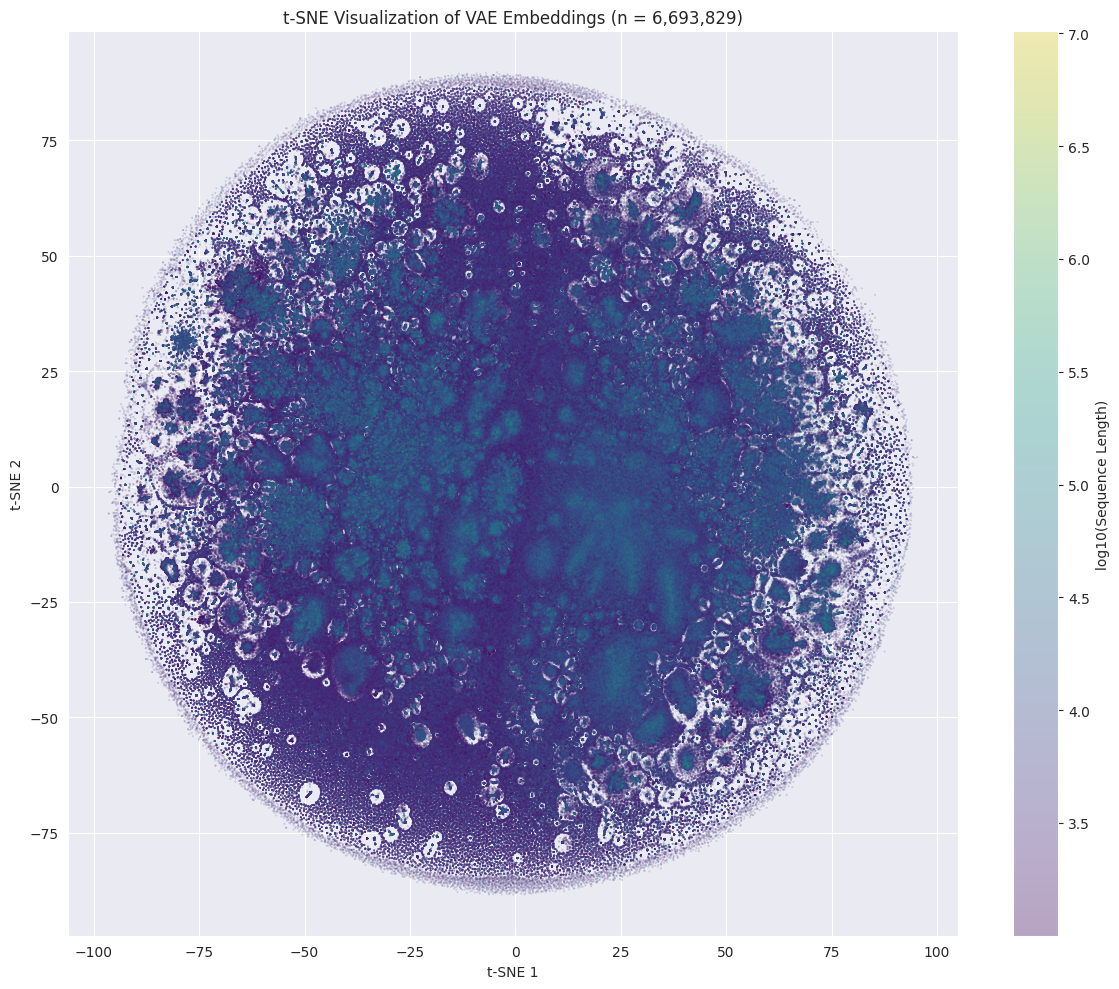

In [24]:
# Plot t-SNE result
fig, ax = plt.subplots(figsize = (12, 10))

# Use scatter with small alpha for 1M points
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = np.log10(tsne_lengths),  # Color by log sequence length
    cmap = 'viridis',
    s = 0.1,
    alpha = 0.3
)
cbar = plt.colorbar(scatter, ax = ax)
cbar.set_label('log10(Sequence Length)')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f't-SNE Visualization of VAE Embeddings (n = {tsne_sample_size:,})')
plt.tight_layout()
plt.show()

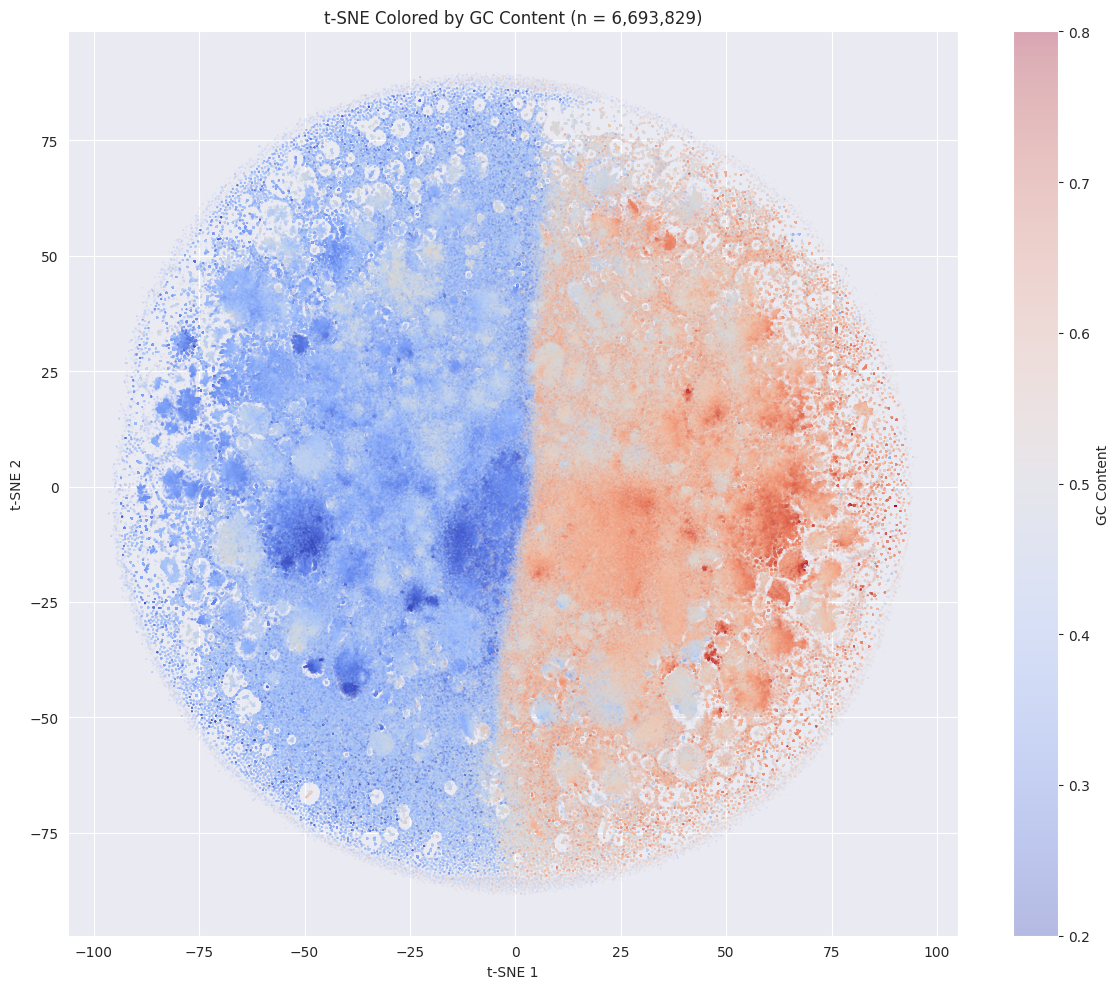

GC content range: 0.000 - 1.000
GC content mean: 0.474


In [25]:
# Plot t-SNE colored by GC content (last column of kmers)
gc_content = kmers[tsne_idx, -1]

fig, ax = plt.subplots(figsize = (12, 10))
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = gc_content,
    cmap = 'coolwarm',
    s = 0.1,
    alpha = 0.3,
    vmin = 0.2,
    vmax = 0.8
)
cbar = plt.colorbar(scatter, ax = ax)
cbar.set_label('GC Content')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f't-SNE Colored by GC Content (n = {tsne_sample_size:,})')
plt.tight_layout()
plt.show()

print(f'GC content range: {gc_content.min():.3f} - {gc_content.max():.3f}')
print(f'GC content mean: {gc_content.mean():.3f}')

SFE sequences: 2,467,377 (36.9%)
SE sequences: 4,226,452 (63.1%)


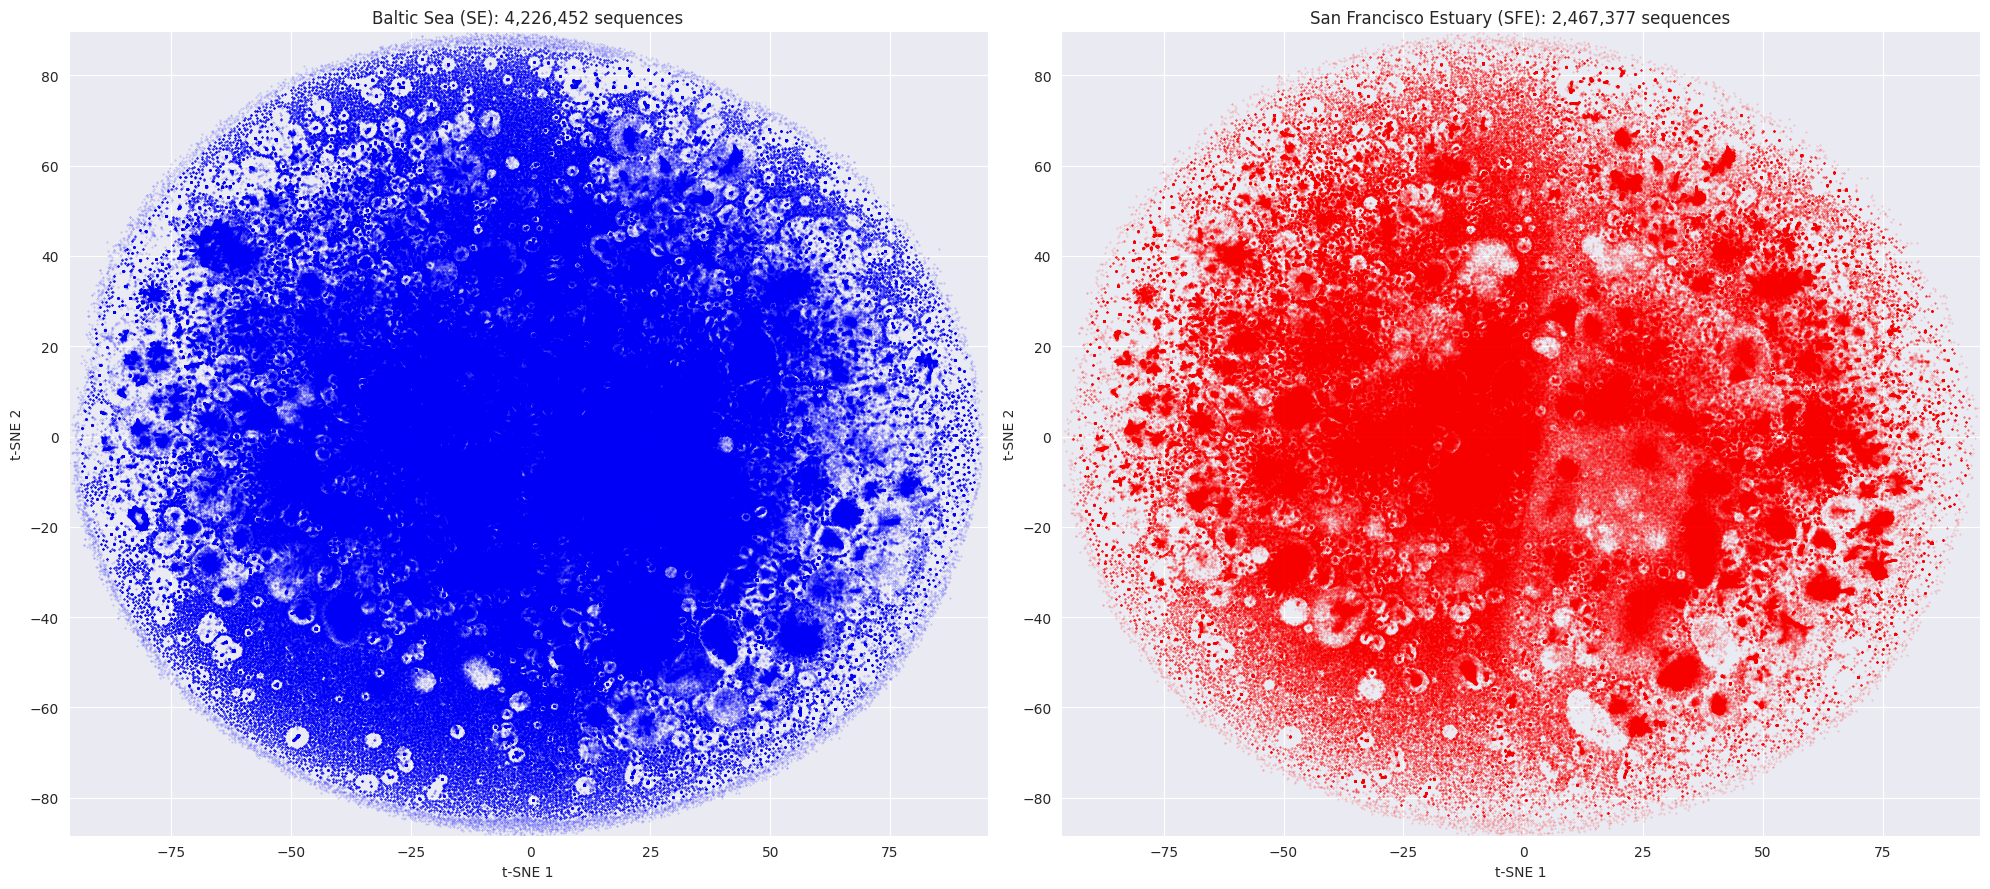

In [26]:
# Plot t-SNE colored by ID prefix (SFE vs SE) - side by side
is_sfe = np.array([id.startswith('SFE') for id in tsne_ids])
is_se = np.array([id.startswith('SE') for id in tsne_ids])

print(f'SFE sequences: {is_sfe.sum():,} ({100 * is_sfe.mean():.1f}%)')
print(f'SE sequences: {is_se.sum():,} ({100 * is_se.mean():.1f}%)')

fig, axes = plt.subplots(1, 2, figsize = (20, 9))

# Left: SE only (Baltic)
axes[0].scatter(
    tsne_result[is_se, 0],
    tsne_result[is_se, 1],
    c = 'blue',
    s = 0.1,
    alpha = 0.3
)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].set_title(f'Baltic Sea (SE): {is_se.sum():,} sequences')

# Right: SFE only (San Francisco Estuary)
axes[1].scatter(
    tsne_result[is_sfe, 0],
    tsne_result[is_sfe, 1],
    c = 'red',
    s = 0.1,
    alpha = 0.3
)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f'San Francisco Estuary (SFE): {is_sfe.sum():,} sequences')

# Match axis limits so they're comparable
xlim = (tsne_result[:, 0].min(), tsne_result[:, 0].max())
ylim = (tsne_result[:, 1].min(), tsne_result[:, 1].max())
for ax in axes:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.tight_layout()
plt.show()

Running HDBSCAN on 6,693,829 points...
Clusters found: 7391
Noise points: 2,825,685 (42.2%)


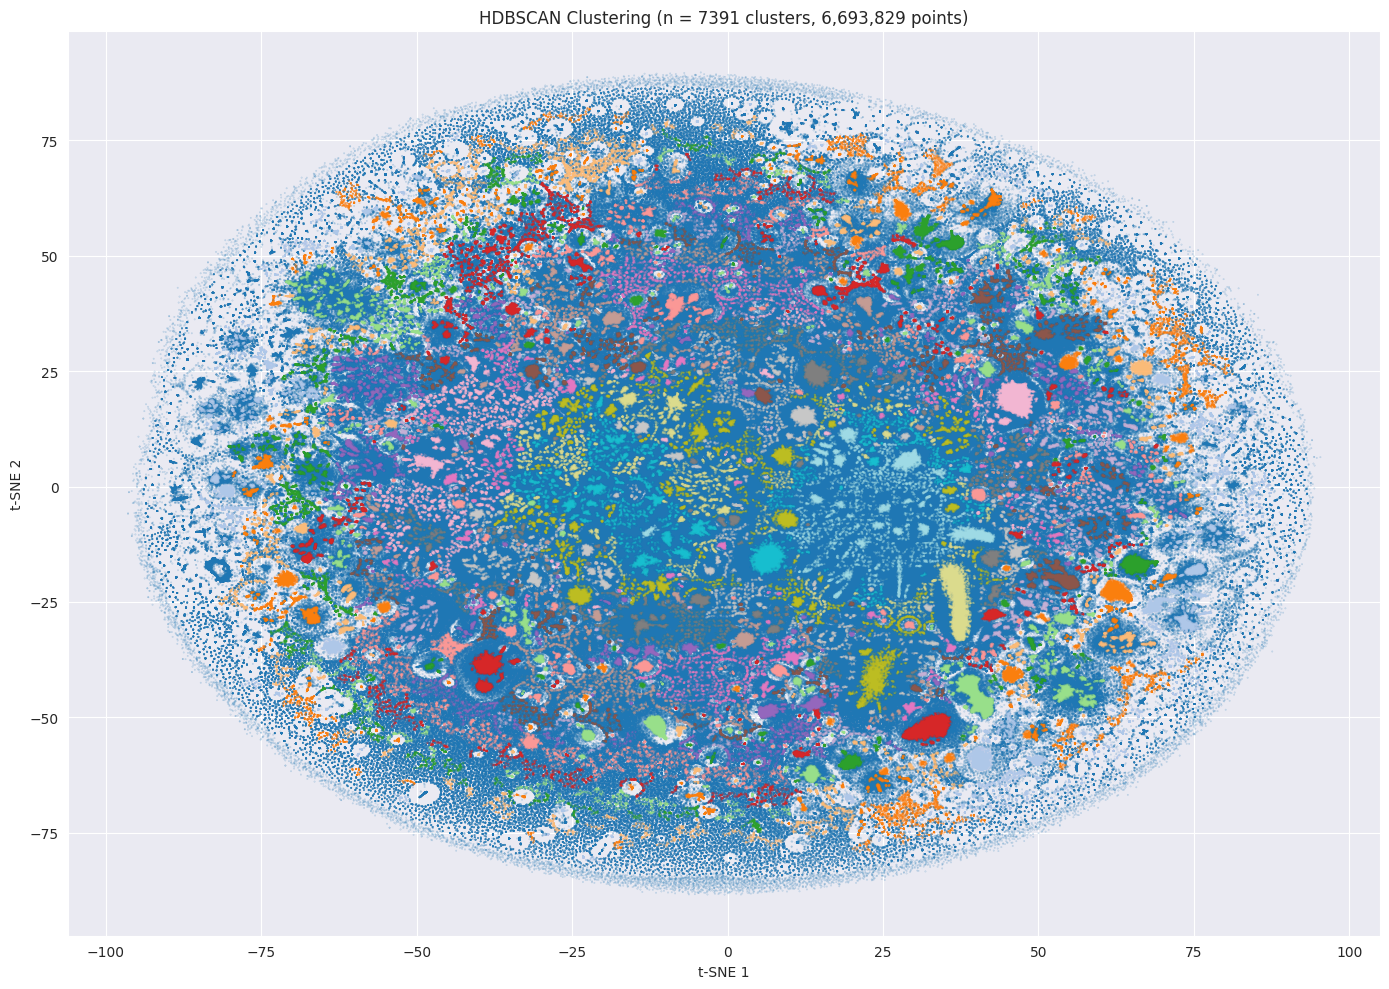

In [27]:
# HDBSCAN clustering on full t-SNE coordinates
from hdbscan import HDBSCAN

print(f'Running HDBSCAN on {len(tsne_result):,} points...')
clusterer = HDBSCAN(min_cluster_size = 100, min_samples = 50)
labels = clusterer.fit_predict(tsne_result)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()

print(f'Clusters found: {n_clusters}')
print(f'Noise points: {n_noise:,} ({100 * n_noise / len(labels):.1f}%)')

# Plot with cluster colors
fig, ax = plt.subplots(figsize = (14, 10))
scatter = ax.scatter(
    tsne_result[:, 0],
    tsne_result[:, 1],
    c = labels,
    cmap = 'tab20',
    s = 0.1,
    alpha = 0.3
)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'HDBSCAN Clustering (n = {n_clusters} clusters, {len(tsne_result):,} points)')
plt.tight_layout()
plt.show()

In [ ]:
# List clusters and save to files
unique_labels = sorted(set(labels) - {-1})  # Exclude noise

# Save cluster sizes to clusters.tsv
with open('clusters.tsv', 'w') as f:
    f.write('cluster\tsize\n')
    for label in unique_labels:
        size = (labels == label).sum()
        f.write(f'{label}\t{size}\n')
    f.write(f'noise\t{(labels == -1).sum()}\n')

print(f'Saved cluster sizes to clusters.tsv')

# Save cluster memberships to cluster_members.tsv
with open('cluster_members.tsv', 'w') as f:
    f.write('cluster\tsequence_ids\n')
    for label in unique_labels:
        mask = labels == label
        ids = embedding_ids[mask]
        f.write(f'{label}\t{",".join(ids)}\n')

print(f'Saved cluster memberships to cluster_members.tsv')

In [28]:
# Phase 1: Distance landscape from kNN graph
# Parse nn1, nn2, and nn50 distances from neighbors TSV

tsv_path = 'Runs/neighbors_SFE_SE_1.tsv'
n_sequences = 6_693_829

nn1_dists = np.empty(n_sequences, dtype = np.float32)
nn2_dists = np.empty(n_sequences, dtype = np.float32)
nn50_dists = np.empty(n_sequences, dtype = np.float32)

with open(tsv_path, 'r') as f:
    for i, line in enumerate(f):
        fields = line.rstrip('\n').split('\t')
        nn1_dists[i] = float(fields[1].split('(')[1].rstrip(')'))
        nn2_dists[i] = float(fields[2].split('(')[1].rstrip(')'))
        nn50_dists[i] = float(fields[-1].split('(')[1].rstrip(')'))
        if (i + 1) % 1_000_000 == 0:
            print(f'Parsed {i + 1:,} / {n_sequences:,} lines...')

print(f'\nParsed all {n_sequences:,} lines')
print(f'nn1  range: {nn1_dists.min():.4f} - {nn1_dists.max():.4f}, mean: {nn1_dists.mean():.4f}, median: {np.median(nn1_dists):.4f}')
print(f'nn2  range: {nn2_dists.min():.4f} - {nn2_dists.max():.4f}, mean: {nn2_dists.mean():.4f}, median: {np.median(nn2_dists):.4f}')
print(f'nn50 range: {nn50_dists.min():.4f} - {nn50_dists.max():.4f}, mean: {nn50_dists.mean():.4f}, median: {np.median(nn50_dists):.4f}')

# Percentiles
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f'nn1 P{p:2d}: {np.percentile(nn1_dists, p):.4f}    nn50 P{p:2d}: {np.percentile(nn50_dists, p):.4f}')

Parsed 1,000,000 / 6,693,829 lines...
Parsed 2,000,000 / 6,693,829 lines...
Parsed 3,000,000 / 6,693,829 lines...
Parsed 4,000,000 / 6,693,829 lines...
Parsed 5,000,000 / 6,693,829 lines...
Parsed 6,000,000 / 6,693,829 lines...

Parsed all 6,693,829 lines
nn1  range: 0.0000 - 52.6219, mean: 16.5516, median: 15.8701
nn2  range: 0.0000 - 52.6795, mean: 17.2238, median: 16.5050
nn50 range: 1.6626 - 54.1881, mean: 18.3553, median: 17.4675
nn1 P 1: 2.1187    nn50 P 1: 5.5489
nn1 P 5: 4.7197    nn50 P 5: 7.8853
nn1 P10: 6.5488    nn50 P10: 9.4619
nn1 P25: 10.4886    nn50 P25: 12.7199
nn1 P50: 15.8701    nn50 P50: 17.4675
nn1 P75: 21.9712    nn50 P75: 23.1977
nn1 P90: 27.2523    nn50 P90: 28.2809
nn1 P95: 30.4802    nn50 P95: 31.6283
nn1 P99: 37.2037    nn50 P99: 38.5293


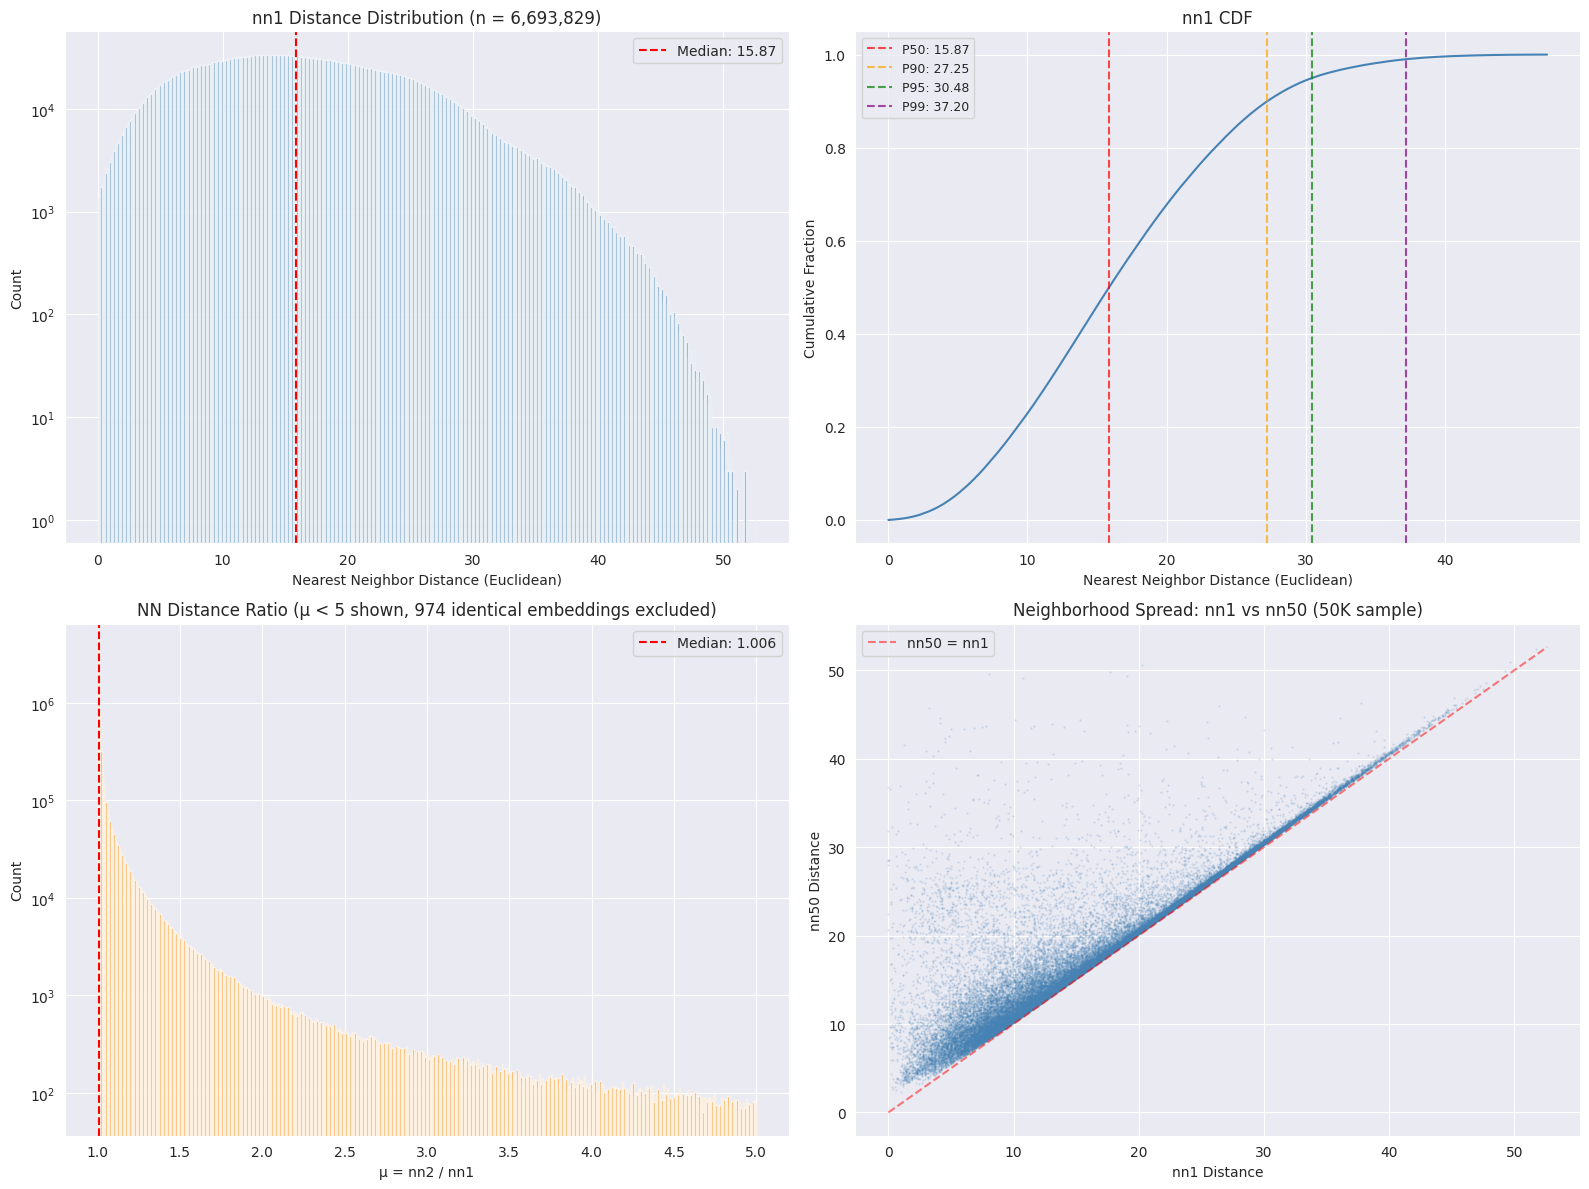


Identical embeddings (nn1 = 0): 974 (0.015%)

μ = nn2/nn1 stats (excluding 974 with nn1 = 0):
  Range: 1.0000 - 532.1213
  Mean: 1.1312, Median: 1.0062
  μ > 2: 123,084 (1.84%) — possible pairs/small groups
  μ > 5: 29,833 (0.45%) — likely singletons/pairs


In [30]:
# Phase 1: Visualize distance landscape

fig, axes = plt.subplots(2, 2, figsize = (16, 12))

# Top-left: nn1 histogram (log y-scale to see the tail)
axes[0, 0].hist(nn1_dists, bins = 500, alpha = 0.7, color = 'steelblue')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Nearest Neighbor Distance (Euclidean)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title(f'nn1 Distance Distribution (n = {n_sequences:,})')
axes[0, 0].axvline(np.median(nn1_dists), color = 'red', linestyle = '--',
                    label = f'Median: {np.median(nn1_dists):.2f}')
axes[0, 0].legend()

# Top-right: nn1 CDF
nn1_sorted = np.sort(nn1_dists)
cdf = np.arange(1, len(nn1_sorted) + 1) / len(nn1_sorted)
# Subsample for plotting (every 1000th point)
step = max(1, len(nn1_sorted) // 10_000)
axes[0, 1].plot(nn1_sorted[::step], cdf[::step], color = 'steelblue', linewidth = 1.5)
axes[0, 1].set_xlabel('Nearest Neighbor Distance (Euclidean)')
axes[0, 1].set_ylabel('Cumulative Fraction')
axes[0, 1].set_title('nn1 CDF')
# Mark key percentiles
for p, color in [(50, 'red'), (90, 'orange'), (95, 'green'), (99, 'purple')]:
    val = np.percentile(nn1_dists, p)
    axes[0, 1].axvline(val, color = color, linestyle = '--', alpha = 0.7,
                        label = f'P{p}: {val:.2f}')
axes[0, 1].legend(fontsize = 9)

# Bottom-left: nn2/nn1 ratio (μ) histogram — exclude nn1 == 0 (identical embeddings)
n_zero = (nn1_dists == 0).sum()
nonzero_mask = nn1_dists > 0
mu = nn2_dists[nonzero_mask] / nn1_dists[nonzero_mask]
mu_finite = mu[np.isfinite(mu)]

axes[1, 0].hist(mu_finite[mu_finite < 5], bins = 500, alpha = 0.7, color = 'darkorange')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('μ = nn2 / nn1')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title(f'NN Distance Ratio (μ < 5 shown, {n_zero:,} identical embeddings excluded)')
axes[1, 0].axvline(np.median(mu_finite), color = 'red', linestyle = '--',
                    label = f'Median: {np.median(mu_finite):.3f}')
axes[1, 0].legend()

# Bottom-right: nn1 vs nn50 (neighborhood spread)
# Subsample for scatter plot
scatter_idx = np.random.default_rng(42).choice(n_sequences, size = 50_000, replace = False)
axes[1, 1].scatter(nn1_dists[scatter_idx], nn50_dists[scatter_idx],
                    s = 0.3, alpha = 0.2, color = 'steelblue')
axes[1, 1].plot([0, nn1_dists.max()], [0, nn1_dists.max()], 'r--', alpha = 0.5,
                label = 'nn50 = nn1')
axes[1, 1].set_xlabel('nn1 Distance')
axes[1, 1].set_ylabel('nn50 Distance')
axes[1, 1].set_title('Neighborhood Spread: nn1 vs nn50 (50K sample)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Summary stats
print(f'\nIdentical embeddings (nn1 = 0): {n_zero:,} ({100 * n_zero / n_sequences:.3f}%)')
print(f'\nμ = nn2/nn1 stats (excluding {n_zero:,} with nn1 = 0):')
print(f'  Range: {mu_finite.min():.4f} - {mu_finite.max():.4f}')
print(f'  Mean: {mu_finite.mean():.4f}, Median: {np.median(mu_finite):.4f}')
print(f'  μ > 2: {(mu_finite > 2).sum():,} ({100 * (mu_finite > 2).mean():.2f}%) — possible pairs/small groups')
print(f'  μ > 5: {(mu_finite > 5).sum():,} ({100 * (mu_finite > 5).mean():.2f}%) — likely singletons/pairs')
del nn1_sorted